In [1]:
from __future__ import print_function
import os
import numpy as np
import gzip
import tensorflow as tf
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from shutil import copyfile
import IPython.core.debugger
import matplotlib.pyplot as plt


In [2]:
dbg = IPython.core.debugger.Pdb()

In [3]:
TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
def maybe_download(filename, work_directory, source_url):
    """Download the data from source_url, unless it's already here
    
        Args:
            filename: string, name of the file in the directory.
            work_directory: string, path to working directory.
            source_url: url to download from if file doesn't exist.
            
        Returns:
             Path to resulting file.
    """
#     dbg.set_trace()
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        temp_file_name, _ = urlretrieve(source_url)
        copyfile(temp_file_name, filepath)
    print('Successfully downloaded', filename, os.stat(filepath).st_size, 'bytes')
    return filepath



In [4]:
def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype = dt)[0]

In [5]:
def extract_images(f):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
    
    Args:
        f: A file object that can be passed into a gzip reader.
    Returns:
        data: A 4D uint8 numpy array [index, y, x, depth].
    Raises:
        ValueError: If the bytestream does not start with 2051
    """
    
    print('Extrating', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
#         dbg.set_trace()
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                            (magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype = np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data

In [6]:
def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arrange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [7]:
def extract_labels(f, one_hot = False, num_classes = 10):
    """Extract the labels into a 1D uint8 numpy array [index].
    
        Args:
          f: A file object that can be passed into a gzip reader.
          one_hot: Does one hot encoding for the result.
          num_classes: Number of classes for the one hot encoding.
        Returns:
          labels: a 1D uint8 numpy array.
        Raises:
          ValueError: If the bytestream does not start with 2049.
    """
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                            (magic, f.name))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        if one_hot:
            return dense_to_one_hot(labels, num_classes)
        return labels

In [8]:
work_dir = "MNIST_data/"
validation_size = 5000

train_path = maybe_download(TRAIN_IMAGES, work_dir, SOURCE_URL + TRAIN_IMAGES)
with open(train_path, 'rb') as f:
    train_images = extract_images(f)
    print(train_images.shape)
    
labels_path = maybe_download(TRAIN_LABELS, work_dir, SOURCE_URL + TRAIN_LABELS)
with open(labels_path, 'rb') as f:
    train_labels = extract_labels(f, one_hot = False)
    
test_path = maybe_download(TEST_IMAGES, work_dir, SOURCE_URL + TEST_IMAGES)
with open(test_path, 'rb') as f:
    test_images = extract_images(f)
    
tlabels_path = maybe_download(TEST_LABELS, work_dir, SOURCE_URL + TEST_LABELS )
with open(tlabels_path, 'rb') as f:
    test_labels = extract_labels(f, one_hot = False)
    
if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'
        .format(len(train_images), validation_size))
validation_images = train_images[:validation_size]
validation_labels = train_labels[:validation_size]
train_images = train_images[validation_size:]
train_labels = train_labels[validation_size:]



Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes
Extrating MNIST_data/train-images-idx3-ubyte.gz
(60000, 28, 28, 1)
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes
Extrating MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
image_size = 28
image_pixel = 255
train_images = train_images.reshape(-1,image_size, image_size)
test_images = test_images.reshape(-1, image_size, image_size)
validation_images = validation_images.reshape(-1, image_size, image_size)
print(train_images.shape)
print(test_images.shape)
print(validation_images.shape)

(55000, 28, 28)
(10000, 28, 28)
(5000, 28, 28)


In [10]:
def load_letter(image_files):
    """
    normalized to have approximately zero mean 
    and standard deviation ~0.5 to make training 
    easier down the road.
    
    Args:
        image_files: 3-D numpy array [index, y, x]
    Return:
        dataset: normalized 3-D numpy array[index, y, x]
    """
    
    dataset = np.ndarray(shape = (image_files.shape[0], image_size, image_size),
                        dtype = np.float32)
    
    num_images = 0
    for index in range(image_files.shape[0]):
        image_data = (image_files[index].astype(float) - image_pixel/2)/image_pixel
        dataset[num_images, :, :] =image_data
        num_images = num_images +1
    dataset = dataset[0:num_images, :, :]
    print(dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

train_dataset = load_letter(train_images)
test_dataset = load_letter(test_images)
validation_dataset = load_letter(validation_images)
del(train_images)
del(test_images)
del(validation_images)

(55000, 28, 28)
Mean: -0.3693
Standard deviation: 0.30816
(10000, 28, 28)
Mean: -0.367486
Standard deviation: 0.31048
(5000, 28, 28)
Mean: -0.369778
Standard deviation: 0.30754


In [11]:
# root = '.'
# pickle_dir = 'MNIST_pickle/'
# def maybe_pickle(dataset,dest_dir,filename, force= False):
#     """
#     pickle the dataset as the pickle file
    
#     Args:
#          dataset: the dataset need to pickle.
#          dest_dir: path where you save the pickle files.
#          filename: str represents the name of the dataset
#     Return:
#          dataset_names: the name of the pickle file
#     """
#     if not os.path.exists(dest_dir):
#         os.mkdir(dest_dir)
#     file_path = os.path.join(root, dest_dir, filename) + '.pickle'
#     if os.path.exists(file_path) and not force:
#         print('%s already present - Skipping pickling.' % filename)
#     else:
#         print('Pickling %s.' % file_path)
#         try:
#             with open(file_path, 'wb') as f:
#                 pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
#         except Exception as e:
#             print('Unable to save data to', filename, ':', e)
#     return file_path

# train_pickle = maybe_pickle(train_dataset, pickle_dir, 'train_dataset' )
# test_pickle = maybe_pickle(test_dataset, pickle_dir, 'test_dataset')
# validation_pickle = maybe_pickle(validation_dataset, pickle_dir, 'validation_dataset')


In [12]:
root = '.'
pickle_dir = 'MNIST_pickle/'
pickle_file = os.path.join(root, pickle_dir, 'MNIST.pickle')
if not os.path.exists(pickle_dir):
        os.mkdir(pickle_dir)
if os.path.exists(pickle_file):
        print('%s already present - Skipping pickling.' % pickle_file)
try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        'validation_dataset':validation_dataset,
        'validation_labels': validation_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)

./MNIST_pickle/MNIST.pickle already present - Skipping pickling.


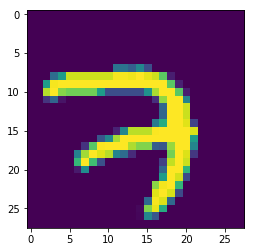

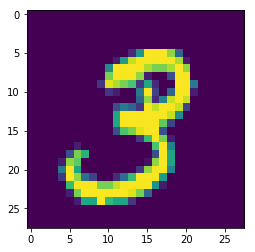

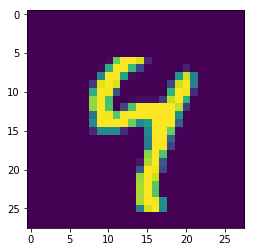

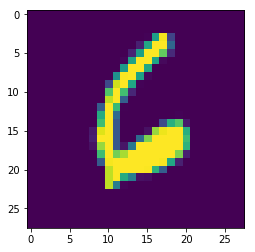

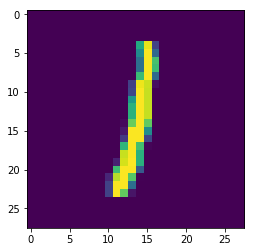

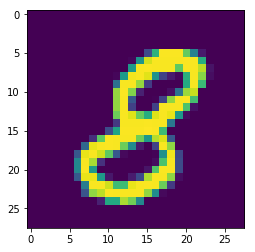

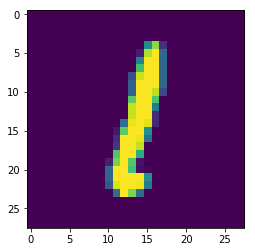

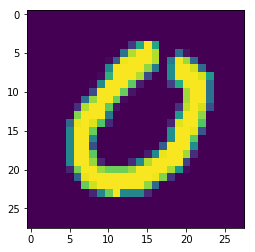

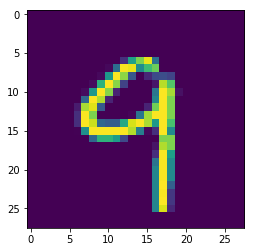

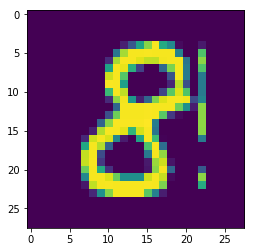

In [13]:

for i in range(10):
    plt.imshow(train_dataset[i])
    plt.show()

In [14]:
print(pickle_file)
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    validation_dataset = save['validation_dataset']
    validation_labels = save['validation_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', validation_dataset.shape, validation_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)


./MNIST_pickle/MNIST.pickle
Training set (55000, 28, 28) (55000,)
Validation set (5000, 28, 28) (5000,)
Test set (10000, 28, 28) (10000,)


In [15]:
num_labels = 10
num_channels = 1

def reformat(dataset, labels):
    dataset = dataset.reshape(-1, image_size, image_size, num_channels)
    labels = (labels[:,None] == np.arange(num_labels)).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(validation_dataset, validation_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (55000, 28, 28, 1) (55000, 10)
Validation set (5000, 28, 28, 1) (5000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [16]:
def accuracy(predictions, labels):
    return (100 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

            

In [32]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
    #Input daa.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size,
                                                           image_size,image_size, num_channels ))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size,
                                                          num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #Varaibles
  
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size,
                                                          num_channels, depth],stddev = 0.1), name = 'fileter1')   
    layer1_biases = tf. Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size,
                                                          depth, depth],stddev = 0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape = [depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size//4*image_size//4
                                                          *depth, num_hidden],stddev = 0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels],
                                                         stddev = 0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
    #Model
    def model(data):
#         dbg.set_trace()
        conv1 = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], padding = 'SAME')
        hidden1 = tf.nn.relu(conv1+layer1_biases)
        pool1 = tf.nn.max_pool(
            hidden1, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
        conv = tf.nn.conv2d(pool1, layer2_weights, [1,1,1,1], padding = 'SAME')
        hidden2 = tf.nn.relu(conv+layer2_biases)
        pool = tf.nn.max_pool(
            hidden2, ksize=[1,2,2,1], strides =[1,2,2,1], padding = 'SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool,[shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases, conv, hidden2, pool
    
    #Training computation.
    logits, conv, hidden, pool = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset)[0])
    test_prediction = tf.nn.softmax(model(tf_test_dataset)[0])
    

    

In [ ]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    dbg.set_trace()
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size) #pick 1001 batches, 16 per batch
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
      print(np.argmax(valid_prediction.eval()[1]))
      plt.imshow(valid_dataset.reshape(-1,image_size,image_size)[1])
      plt.show()
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [ ]:
()